In [1]:
import matplotlib.pyplot as plt
import numpy as np

import zipfile
import os

from itertools import chain
from matplotlib.ticker import StrMethodFormatter

#### Author:
Simon Hackl, 28.02.2021

#### Project:
Elaboration of a best practice for hybrid and long read de novo assembly of bacterial genomes utilizing Illumina and Oxford Nanopore Technologies reads

---

This notebook is used to analyze the results of the `S3_readQualityControl.sh` and `S4_readSubsampling.sh` scripts. In order to use this notebook please ensure that all result files were generated and stored in the directories as it is described in the respective scripts.

---

#### Computing/extracting quality and coverage statistics and coverage visualization:

The following methods are used to extract quality and coverage features from the `.cov` files generated by mapping reads with `minimap2` and analysis with `samtools depth` as well as the `.zip` reports generated by running `FastQC`.

From the extracted features a summary file will be generated that contains information about:
- the mean per read sequence quality (Phred score) extracted from the `FastQC` reports (only for non sub-samples).
- the mean depth of coverage regarding the reference genome.
- the percentage of reference genome positions with zero coverage depth.
- the expected breadth of coverage, according to the Lander-Waterman model, defined as $1 - exp( -C )$ for a given coverage $C$.

In addition, visualizations for the non sub-sample read sets are generated that depict the coverage along the reference genomes.

In [2]:
def coverageStatistics( sampleIdentifier, covFileIdentifier ) :
    ''' From the input parameters a .cov file is accessed from which the mean coverage depth
    and the percentage of the reference genome with zero coverage depth is reported.
    
    Parameters
    ----------
    sampleIdentifier : str
        Identifier for the reference set, one of CFT073, MGH78578, RN4220
        
    covFileIdentifier : str
        Identifier for the specific read set, equals the name of the .cov file generated
        by `samtools depth` with script S3 and S4, e.g. 'SRR8482567_1_2' for the MGH78578 short reads.
    '''
    
    # Parse .cov file into dictionary, each segment (plasmid, part of genome) identifier 
    # is used as a key pointing to a list of per position coverages along that segment.
    with open( './results/coverage/' + sampleIdentifier + '/' + covFileIdentifier + '.cov' ) as cf :
        line = cf.readline( )
        perPositionCoverage = { }
        while line:
            chrom, index, cov = line.strip( ).split( '\t' )
            if chrom in perPositionCoverage :
                perPositionCoverage[ chrom ].append( int( cov ) )
            else :
                perPositionCoverage[chrom ] = [ int( cov ) ]
            line = cf.readline()
            
    # Iterate over each position and sum up the depth of coverage and number of positions.
    # Thereby, positions with zero coverage are recorded.
    coverageSum = 0
    positionsNoCoverage = 0
    positionsSum = 0
    for chrom, coverages in perPositionCoverage.items( ) :
        coverageSum += sum( coverages )
        positionsNoCoverage += sum( [ coverage == 0 for coverage in coverages ] )
        positionsSum += len( coverages )
    
    # Compute mean coverage depth.
    meanCoverage = ( coverageSum / positionsSum )
    
    # Compute percentage of positions with zero coverage.
    noCoverage = ( positionsNoCoverage / positionsSum ) * 100
    
    return meanCoverage, noCoverage

In [3]:
def qualityStatistics( sampleIdentifier, fastqcFileIdentifier ) :
    ''' From the input parameters a .zip file (FastQC report) is accessed from which the mean per
    read sequence Phred quality score is calculated.
    
    Parameters
    ----------
    sampleIdentifier : str
        Identifier for the reference set, one of CFT073, MGH78578, RN4220
        
    fastqcFileIdentifier : str
        Identifier for the specific read set, equals the name of the .zip file generated
        by FastQC with script S3, e.g. 'SRR8482567_1_fastqc' for the MGH78578 forward strand short reads.
    '''
    
    # Parse .zip file. The section containing the per sequence quality score
    # distribution is used to compute the mean per sequence quality.
    numberOfSequences = 0
    sumSequenceQuality = 0
    meanSequenceQuality = 0
    parse = False
    with zipfile.ZipFile( './results/fastqc/' + sampleIdentifier + '/' + fastqcFileIdentifier + '_fastqc.zip' ) as myzip:
        with myzip.open( fastqcFileIdentifier + '_fastqc/fastqc_data.txt' ) as myfile:
            lines = str( myfile.read( ).decode("utf-8")  ).split( '\n' )
            for line in lines :
                if line.startswith( 'Total Sequences' ) :
                    numberOfSequences = int( line.split( '\t' )[1] )
                elif line.startswith( '>>Per sequence quality scores' ) or parse == True :
                    parse = True
                    if line.startswith( '#Quality' ) :
                        continue
                    elif line.startswith( '>>END' ) :
                        parse = False
                        meanSequenceQuality = sumSequenceQuality / numberOfSequences
                    elif parse == True and not line.startswith( '>>' ) :
                        quality, count = line.strip( '\n' ).split( '\t' )
                        quality = int( quality )
                        count = int( float( count ) )
                        sumSequenceQuality += quality * count
    return meanSequenceQuality

In [4]:
def writeReadStatistics( ) :
    ''' Calls the `coverageStatistics` and `qualityStatistics` methods for each pair of sample- and read identifiers used
    for the project. All extracted and computed features are written into a summary file as described at the beginning
    of this notebook.
    '''
    
    # Helper method to calculate Lander–Waterman expected breadth of coverage.
    getExpectedCoverage = lambda cov : np.round( ( 1 - np.exp( - cov ) ) * 100, 2 )
    
    # Generate the results .csv file.
    with open( "./supplementary_files/F3_readStatistics.csv", "w+" ) as resultFile :
        # Write header into result file.
        resultFile.write( "IDENTIFIER,MEAN_SEQUENCE_QUALITY,MEAN_COVERAGE_DEPTH,PERCENTAGE_ZERO_COVERAGE_DEPTH,EXPECTED_COVERAGE_BREADTH\n" )
        # For each pair of sample- and read-identifiers used in the project...
        for sample, longreadID, shortreadID, hasSubsample, processShortreads in [
            ( "CFT073", "SRR8494940", "SRR8482585", True, True ),
            ( "MGH78578", "SRR8494915", "SRR8482567", False, True ),
            ( "RN4220", "QNFLR049AW~guppy3210", "QNFLR056AF", True, True ),
            ( "RN4220", "QNFLR049AW~guppy4011", "-", True, False )
        ] :
            # ... an empty line specifying the sample identifier for the following lines is written.
            resultFile.write( sample + ",,,,\n" )
            # ... short read statistics are computed and written to the result file.
            if processShortreads :
                meanCoverage, noCoverage = coverageStatistics( sample, shortreadID + "_1_2" )
                qual1 = qualityStatistics( sample, shortreadID + "_1" )
                qual2 = qualityStatistics( sample, shortreadID + "_2" )
                meanReadQuality = ( qual1 + qual2 ) / 2
                resultFile.write( ','.join( [
                    shortreadID,
                    str( np.round( meanReadQuality, 2 ) ),
                    str( np.round( meanCoverage, 2 ) ) + 'X',
                    str( np.round( noCoverage, 2 ) ) + '%',
                    str( getExpectedCoverage( meanCoverage ) ) + '%'
                ] ) + '\n' ) 
            # ... long read statistics are computed and written to the result file.
            meanCoverage, noCoverage = coverageStatistics( sample, longreadID + "-t" )
            meanReadQuality = qualityStatistics( sample, longreadID + "-t" )
            resultFile.write( ','.join( [
                longreadID,
                str( np.round( meanReadQuality, 2 ) ),
                str( np.round( meanCoverage, 2 ) ) + 'X',
                str( np.round( noCoverage, 2 ) ) + '%',
                str( getExpectedCoverage( meanCoverage ) ) + '%'
            ] ) + '\n' ) 
            # ... long read sub-sample files are considered, if present.
            if hasSubsample :
                for coverage in [ '-' + str( c ) + 'X' for c in [ 200, 150, 100, 80, 60, 40, 20, 15, 10, 8, 6, 4, 2, 1 ] ] :
                    meanCoverage, noCoverage = coverageStatistics( sample, longreadID + "-t" + coverage )
                    resultFile.write( ','.join( [
                        longreadID + coverage,
                        '-',
                        str( np.round( meanCoverage, 2 ) ) + 'X',
                        str( np.round( noCoverage, 2 ) ) + '%',
                        str( getExpectedCoverage( meanCoverage ) ) + '%'
                    ] ) + '\n' ) 

Now, the `writeReadStatistics` method is run to write the read coverage and quality summary file.

In [5]:
writeReadStatistics( )

---

The following methods are used to compute a coverage profile for a .cov file and a reference genome. The per position depth of coverage information of the accessed .cov file is split into a set of chunks, i.e. fixed length intervals of reference genome positions. For each chunk the minimal, maximal and mean depth of coverage is plotted and it is indicated if any position with zero coverage is contained in the chunk.

In [6]:
def getCoverageChunks( sampleIdentifier, covFileIdentifier, resolution = 10000, appendSegments = False ) :
    ''' Accesses a .cov file and returns a dictionary storing coverage information for fixed length intervals (chunks)
    along the reference genome.
    
    Parameters
    ----------
     sampleIdentifier : str
        Identifier for the reference set, one of CFT073, MGH78578, RN4220
        
    covFileIdentifier : str
        Identifier for the specific read set, equals the name of the .cov file generated
        by `samtools depth` with script S3 and S4, e.g. 'SRR8482567_1_2' for the MGH78578 short reads.
        
    resolution : int
        Default 10000; Specifies the size of each chunk as the genome length divided by the resolution.
        
    appendSegments : bool
        Default False; If set to True, a multipartite genome will be considered as one continuos segment.
        Should be set if many genomic segments exist (e.g. 118 contigs for the RN4220 reference set).
    '''
    
    # First the .cov file is accessed to parse the per position coverage into a dictionary.
    # The dictionary will store a key for each genomic segment.
    with open( './results/coverage/' + sampleIdentifier + '/' + covFileIdentifier ) as cf :
        perPositionCoverage = { }
        line = cf.readline()
        while line:
            seg, index, cov = line.strip( ).split( '\t' )
            if seg in perPositionCoverage :
                perPositionCoverage[ seg ].append( int( cov ) )
            else :
                perPositionCoverage[ seg ] = [ int( cov ) ]
            line = cf.readline()
        # If appendSegments is set to True, append all per position coverages accessible via
        # a common key / segment identifier.
        if appendSegments :
            commonKey = list( perPositionCoverage.keys( ) )[ 0 ].split( "." )[ 0 ]
            commonCoverages = list( chain( *perPositionCoverage.values( ) ) )
            del perPositionCoverage
            perPositionCoverage = dict( [ ( commonKey, commonCoverages ) ] )
        
    # Compute coverage features for each genomic segment.
    perSegmentChunkData = { }
    for seg in list( perPositionCoverage.keys( ) ) :
        perSegmentChunkData[ seg ] = { }
        positions = len( perPositionCoverage[ seg ] )
        
        # If the given resolution would lead to less than 15 chunks, the resolution is decreased.
        resolutionChanged = False
        if ( positions / 15 ) <= resolution :
            orgResolution = resolution
            resolutionChanged = True
            while ( positions / 15 ) <= resolution :
                resolution = resolution / 15
                
        # Split per segment coverage information into cunks and compute mean, min and max coverage.
        chunks = np.array_split( perPositionCoverage[ seg ], np.ceil( positions / resolution ) )
        perSegmentChunkData[ seg ][ "mean" ] = [ np.mean( chunk ) for chunk in chunks ]
        perSegmentChunkData[ seg ][ "min" ] = [ min( chunk ) for chunk in chunks ]
        perSegmentChunkData[ seg ][ "max" ] = [ max( chunk ) for chunk in chunks ]
        perSegmentChunkData[ seg ][ "chunkCount" ] = len( chunks )
        perSegmentChunkData[ seg ][ "chunkLength" ] = len( chunks[ -1 ] )
            
        if resolutionChanged :
            resolution = orgResolution
            
    return perSegmentChunkData

In [7]:
def formatter( x, pos, chunkStarts ) :
    ''' Converts x-tick information into a genomic starting position for plotting ( in the
    form ab * 10^x, where ab are the two most significant digits of the position and x are the remaining
    digits, e.g. 50,000,000 will be converted to 50*10^5 ).
    
    Parameters
    ----------
    x : float
        The value of the x-tick, i.e. its label.
        
    pos : int
        The position of the x-tick on the plot.
        
    chunkStarts : list
        Contains the genomic starting position of each chunk.
    '''
    try :
        chunkPosition = chunkStarts[ int( x ) ] + 1
        cutDigits = len( str( chunkPosition )[2:] )
        return '$' + str( np.round( chunkPosition, cutDigits ) )[:2] + ' \cdot 10^' + str( cutDigits ) + '$'
    except IndexError :
        pass

In [8]:
def plotCoverage( sampleIdentifier, coverageFiles, colors, resolution = 10000, appendSegments = False, size = 10 ) :
    ''' Generates a plot which visualizes the information of a .cov file split into fixed length intervals (chunks), i.e.
    the mean, minimal and maximal depth of coverage. In addition chunks with a zero coverage depth position are highlighted.
    
    If multiple .cov files are specified, all information will be visualized in one plot - the .cov file has to be
    generated regarding the same reference genome.
    
    The length of the colors list has to match the number of passed .cov files.
    
    Parameters
    ----------
    sampleIdentifier : str
        Identifier for the reference set, one of CFT073, MGH78578, RN4220
        
    coverageFiles : list
        The names of .cov files that are accessed for visualization.
        
    colors : list
        A list of matplotlib color names used for visualizing each passed .cov file in a unique color.
        
    resolution : int
        Default 10000; Specifies the size of each chunk as the genome length divided by the resolution.
        
    appendSegments : bool
        Default False; If set to True, a multipartite genome will be considered as one continuos segment.
        Should be set if many genomic segments exist (e.g. 118 contigs for the RN4220 reference set).
        
    size : int
        The size of the figure.
    '''
    
    # Dependent on the passed figure size, define sizes for plot elements.
    largeTextSize = size * 1.5
    smallTextSize = size * 1.3
    ms = 0.2 * size
    lw = 0.05 * size
    
    # Pass each specified .cov file to the getCoverageChunks method.
    perFileCoverageData = { }
    for coverageFile in coverageFiles :
        perFileCoverageData[ coverageFile ] = getCoverageChunks( sampleIdentifier, coverageFile, resolution = resolution, appendSegments = appendSegments )

    # The first file is accessed to get a list of genomic segments, each .cov file has to specify the same segments.
    firstFile = list( perFileCoverageData.keys( ) )[ 0 ]
    segments = list( perFileCoverageData[ firstFile ].keys( ) )
    
    # For each segment...
    for segment in segments :
        
        # ...calculate the genomic starting positions of each chunk.
        chunkCount = perFileCoverageData[ firstFile ][ segment ][ "chunkCount" ]
        chunkLength = perFileCoverageData[ firstFile ][ segment ][ "chunkLength" ]
        chunkStarts = np.arange( 0, chunkCount )
        segmentStarts = [ chunkLength * chunkStart for chunkStart in chunkStarts ]
        
        # ...plot the information computed with the getCoverageChunks method.
        plt.figure( figsize = ( size, ( size / ( 1.618 / 0.5 ) ) ) )
        for coverageFile, color in zip( coverageFiles, colors ) :
            plt.plot( chunkStarts, perFileCoverageData[ coverageFile ][ segment ][ "mean" ], linewidth=0.0, marker=2, markersize=ms*2, color=color, label="mean coverage in chunk" )
            plt.fill_between( chunkStarts, perFileCoverageData[ coverageFile ][ segment ][ "min" ], perFileCoverageData[ coverageFile ][ segment ][ "max" ], color=color, alpha=0.1, label="min. and max. coverage in chunk" )
            zeroCovIndicator = [ x if x == 0 else np.nan for x in perFileCoverageData[ coverageFile ][ segment ][ "min" ] ]
            if zeroCovIndicator.count( 0 ) > 0 :
                plt.scatter( chunkStarts, zeroCovIndicator, color="black", marker="v", s=ms*4, label = "chunk with zero coverage position (" + str( zeroCovIndicator.count( 0 ) ) + " in total)" )
        
        plt.xlabel( "absolute start position of chunk in genomic segment", fontsize = largeTextSize )
        plt.xlim( 0 - chunkCount / 100, chunkCount + chunkCount / 100 )
        plt.xticks( fontsize = smallTextSize )
        plt.gca( ).xaxis.set_major_formatter( lambda x, pos : formatter( x, pos, segmentStarts ) )
        
        plt.ylabel( "depth of coverage", fontsize = largeTextSize  )
        plt.yticks( fontsize = smallTextSize )
        
        plt.title( 'depth of coverage of ' + str( chunkLength ) + " bp long chunks across reference \n" + sampleIdentifier + ", " + segment + " regarding read set " + ", ".join( [ cf.split( "-" )[ 0 ].split( "_" )[ 0 ] for cf in coverageFiles ] ), fontsize = largeTextSize )
        plt.legend( fontsize = smallTextSize )

In the following the `plotCoverage` method is run for all non sub-sample .cov files.

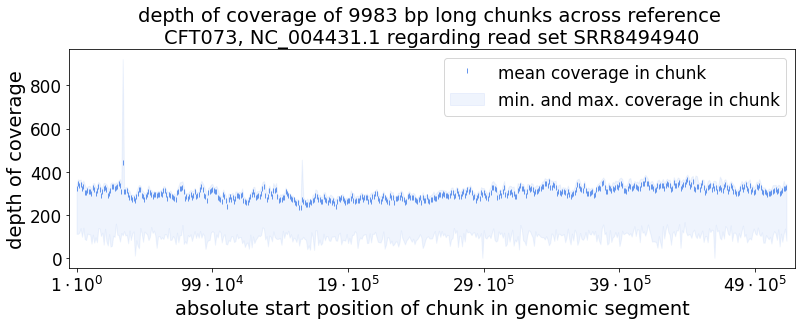

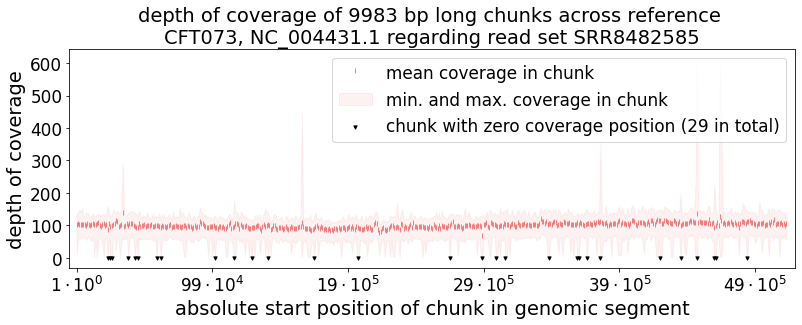

In [9]:
plotCoverage( "CFT073", [ "SRR8494940-t.cov" ], [ 'cornflowerblue' ], size=13 )
plotCoverage( "CFT073", [ "SRR8482585_1_2.cov" ], [ 'lightcoral' ], size=13 )

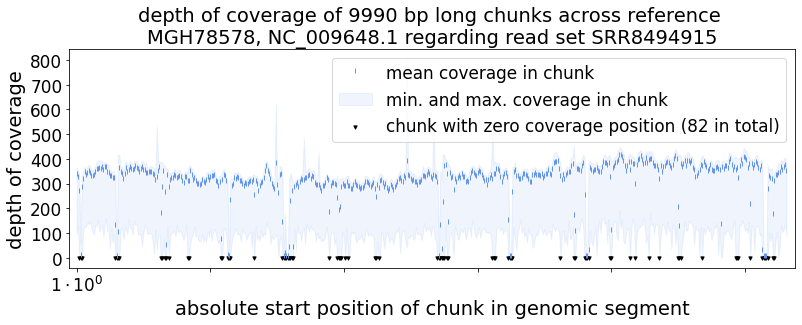

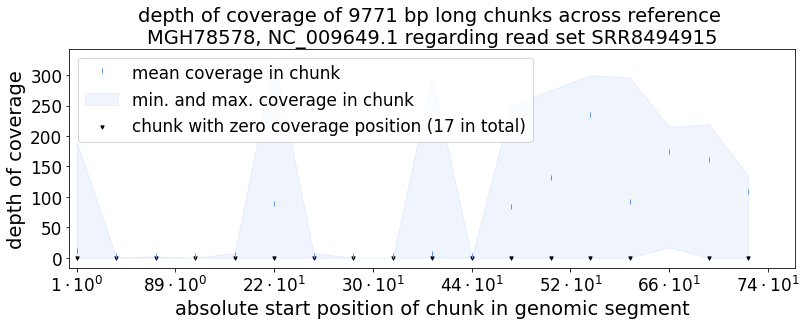

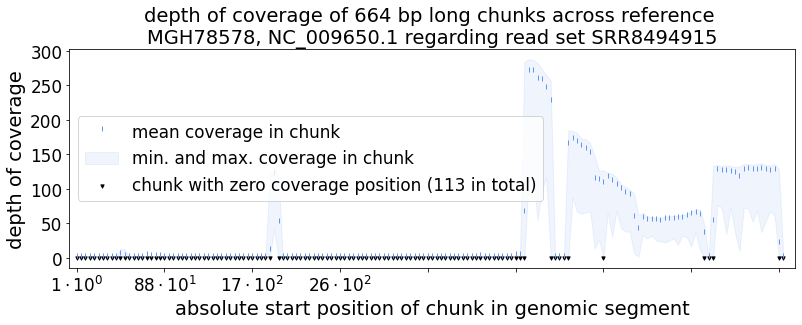

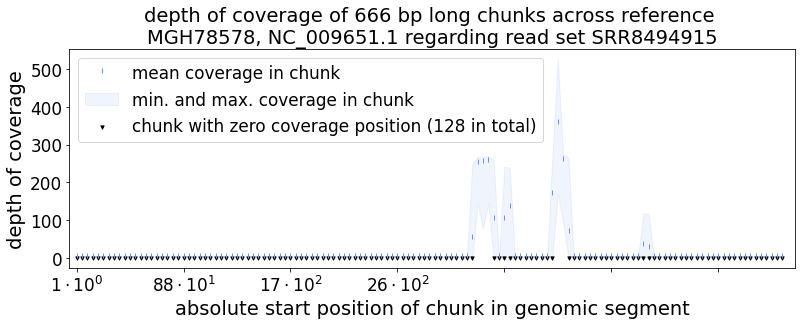

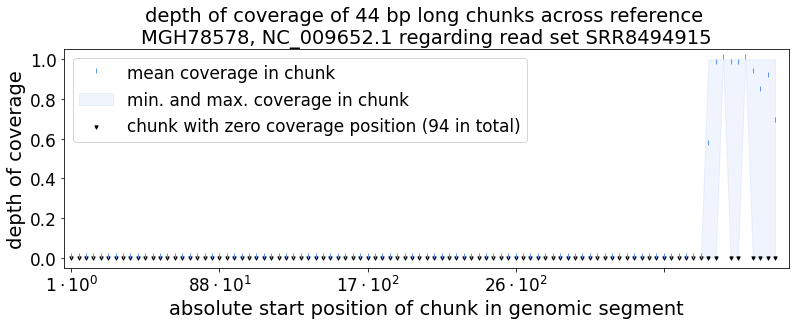

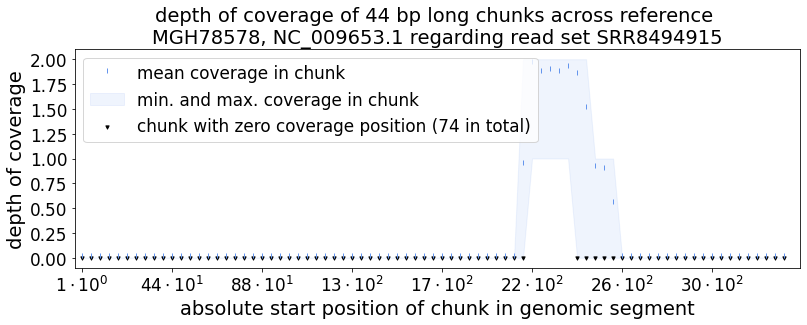

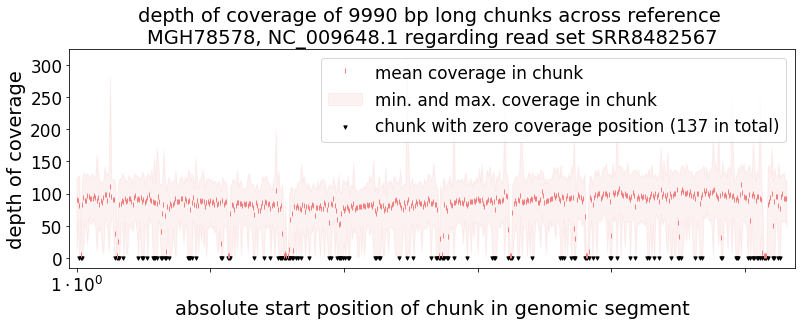

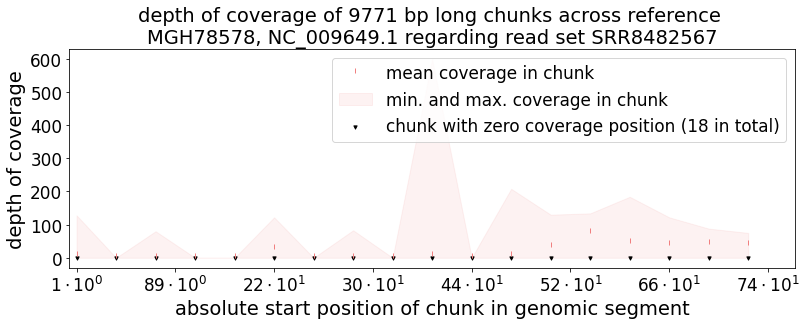

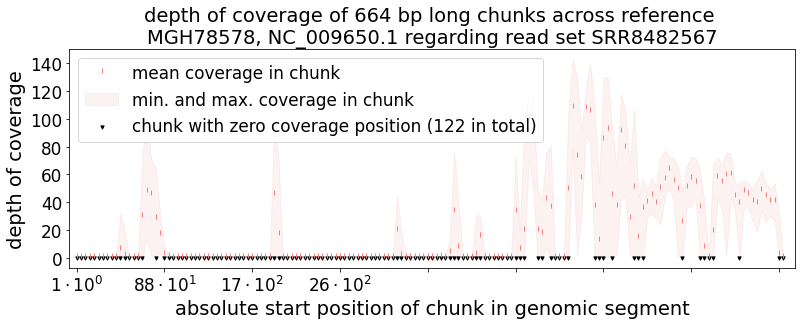

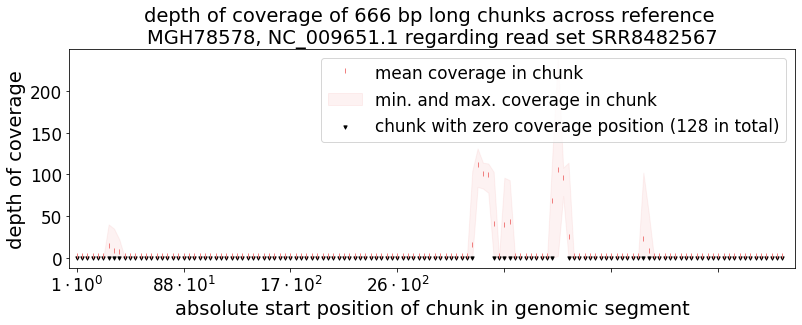

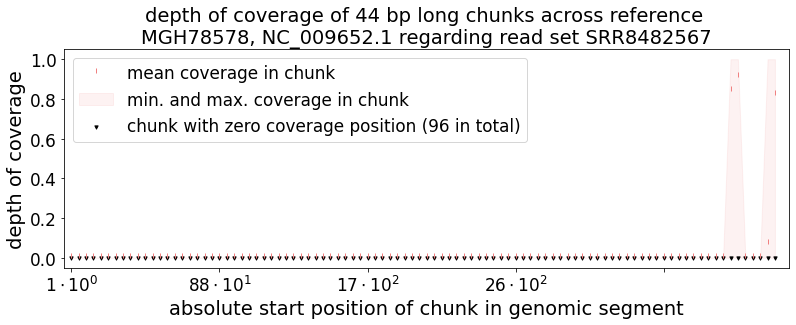

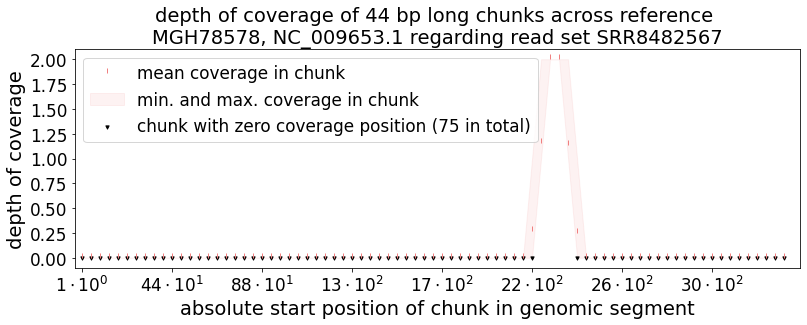

In [12]:
plotCoverage( "MGH78578", [ "SRR8494915-t.cov" ], [ 'cornflowerblue' ], size=13 )
plotCoverage( "MGH78578", [ "SRR8482567_1_2.cov" ], [ 'lightcoral' ], size=13 )

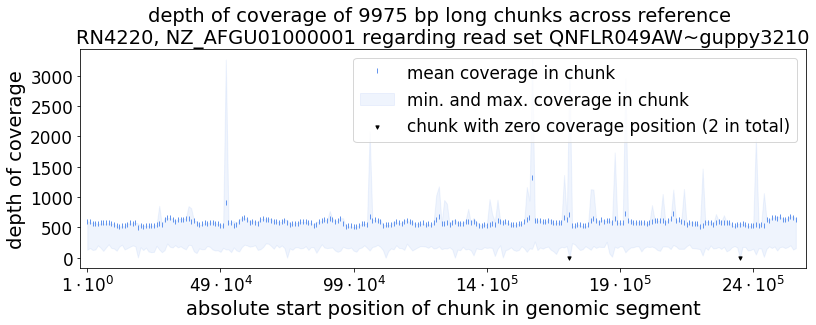

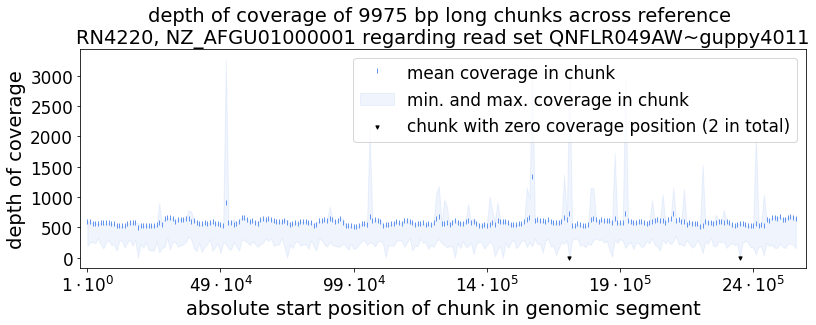

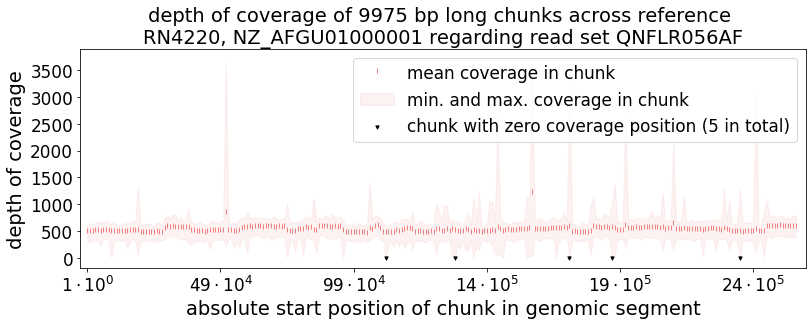

In [11]:
plotCoverage( "RN4220", [ "QNFLR049AW~guppy3210-t.cov" ], [ 'cornflowerblue' ], appendSegments = True, size=13 )
plotCoverage( "RN4220", [ "QNFLR049AW~guppy4011-t.cov" ], [ 'cornflowerblue' ], appendSegments = True, size=13 )
plotCoverage( "RN4220", [ "QNFLR056AF_1_2.cov" ], [ 'lightcoral' ], appendSegments = True, size=13 )